# MRI Classification Using PyTorch

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from torchvision.datasets import ImageFolder
import seaborn as sns
import shutil
import json
import gc

LEARNING_RATE = 0.00001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 8
DROPOUT_RATE = 0.4
PRETRAINED_WEIGHTS = True

NUM_EPOCHS = 20
PATIENCE = 5


## Data Preparation
Load the dataset and split it into training and validation sets, starting with first fold generated by data_preparation.ipynb

In [2]:
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)

mean = mean_std['mean']
std = mean_std['std']

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load data for fold 0
k_folds = 5
base_dir = 'dataset_kfold'
fold = 0
train_dir = os.path.join(base_dir, f'fold_{fold}', 'train')
val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
fold += 1

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

## Define the Model

In [3]:
# Define the ResNet model
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleResNet, self).__init__()
        self.model = models.resnet50(pretrained=PRETRAINED_WEIGHTS)
        self.model.fc = nn.Sequential(
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet(num_classes=num_classes).to(device)

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [5]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return epoch_loss, accuracy

# Define the validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probs.extend(torch.softmax(output, dim=1).cpu().numpy())  # Get probabilities

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return val_loss, accuracy, all_preds, all_labels, all_probs


## Start training the model

In [6]:
# Training and validation loop with early stopping
num_epochs = NUM_EPOCHS
patience = PATIENCE
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []
all_probs = []  # To store the probabilities for AUC-ROC

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc, preds, labels, probs = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_preds.extend(preds)
    all_labels.extend(labels)
    all_probs.extend(probs)
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
          f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print('Early stopping!')
        break
    
# Calculate AUC-ROC
all_probs = np.array(all_probs)  # Convert to numpy array
auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average=None)
for i, class_auc in enumerate(auc_roc):
        print(f"AUC-ROC for class {val_dataset.classes[i]}: {class_auc:.4f}")

Epoch 0, Loss: 1.2816, Accuracy: 41.41%
Validation Loss: 1.0894, Accuracy: 70.83%
Epoch 1/20 - Train loss: 1.2816, Train accuracy: 41.4062 - Val loss: 1.0894, Val accuracy: 70.8333
Epoch 1, Loss: 0.9925, Accuracy: 64.84%
Validation Loss: 0.7776, Accuracy: 81.25%
Epoch 2/20 - Train loss: 0.9925, Train accuracy: 64.8438 - Val loss: 0.7776, Val accuracy: 81.2500
Epoch 2, Loss: 0.8426, Accuracy: 72.92%
Validation Loss: 0.5492, Accuracy: 88.54%
Epoch 3/20 - Train loss: 0.8426, Train accuracy: 72.9167 - Val loss: 0.5492, Val accuracy: 88.5417
Epoch 3, Loss: 0.7051, Accuracy: 77.60%
Validation Loss: 0.4776, Accuracy: 88.54%
Epoch 4/20 - Train loss: 0.7051, Train accuracy: 77.6042 - Val loss: 0.4776, Val accuracy: 88.5417
Epoch 4, Loss: 0.6118, Accuracy: 81.25%
Validation Loss: 0.3677, Accuracy: 90.62%
Epoch 5/20 - Train loss: 0.6118, Train accuracy: 81.2500 - Val loss: 0.3677, Val accuracy: 90.6250
Epoch 5, Loss: 0.5331, Accuracy: 81.77%
Validation Loss: 0.2896, Accuracy: 92.71%
Epoch 6/20 - 

## Visualize

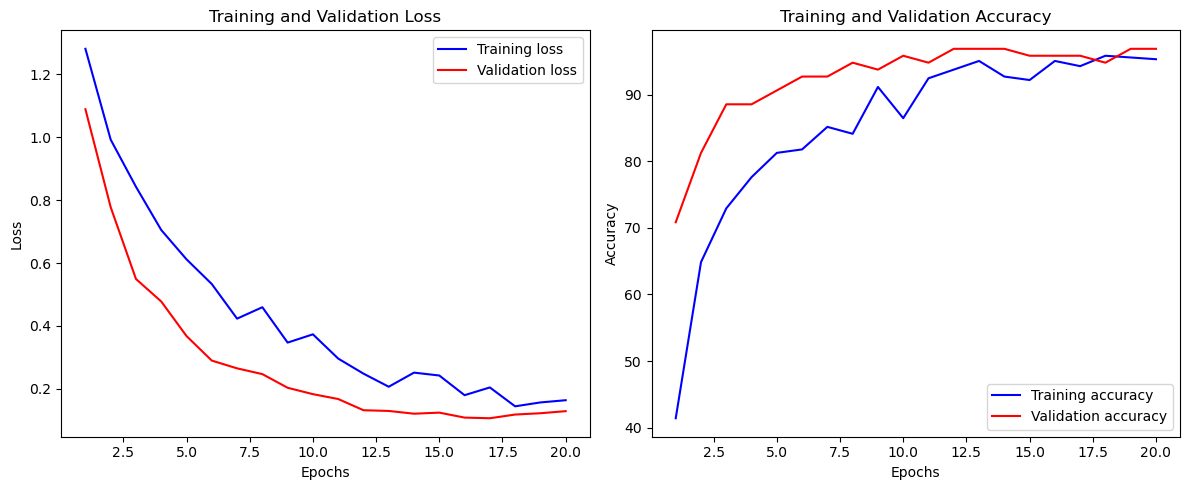

In [7]:
# Plotting the results
actual_epochs = range(1, epoch + 2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(actual_epochs, train_losses, 'b', label='Training loss')
plt.plot(actual_epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(actual_epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(actual_epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 1000x700 with 0 Axes>

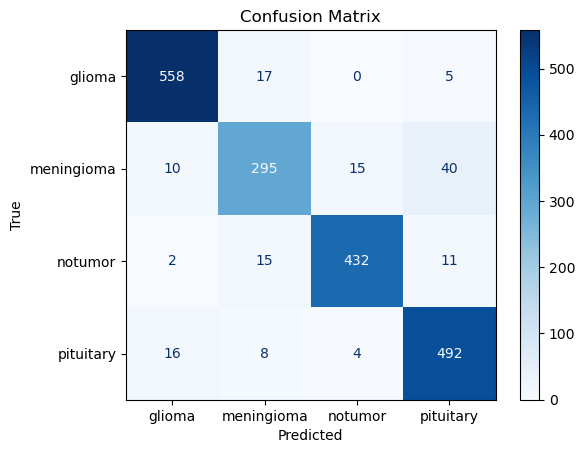

In [8]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Remaining k-fold, train and visualize

In [9]:
fold_results = []

# Loop over each fold
for f in range(1, k_folds):
    print(f'Fold {f + 1}/{k_folds}')

    # Load data for fold
    train_dir = os.path.join(base_dir, f'fold_{f}', 'train')
    val_dir = os.path.join(base_dir, f'fold_{f}', 'val')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Set device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleResNet(num_classes=num_classes).to(device)

    # Optimizer and criterion
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    # Early stopping parameters
    num_epochs = NUM_EPOCHS
    patience = PATIENCE
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []
    all_probs = []

    # Training loop with early stopping
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc, preds, labels, probs = validate(model, device, val_loader, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        all_preds.extend(preds)
        all_labels.extend(labels)
        all_probs.extend(probs)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
              f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model if necessary
            torch.save(model.state_dict(), f'best_model_fold_{f}.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    all_probs = np.array(all_probs)
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average=None)
    
    # Store fold results
    fold_results.append({
        'fold': f,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss,
        'conf_matrix': conf_matrix,
        'val_true_classes': all_labels,
        'val_predictions': all_preds,
        'auc_roc': auc_roc
    })

    # Free CUDA memory after training
    torch.cuda.empty_cache()
    gc.collect()

Fold 2/5


/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.2922, Accuracy: 40.89%
Validation Loss: 1.1694, Accuracy: 58.33%
Epoch 1/20 - Train loss: 1.2922, Train accuracy: 40.8854 - Val loss: 1.1694, Val accuracy: 58.3333
Epoch 1, Loss: 0.9728, Accuracy: 71.61%
Validation Loss: 0.8896, Accuracy: 71.88%
Epoch 2/20 - Train loss: 0.9728, Train accuracy: 71.6146 - Val loss: 0.8896, Val accuracy: 71.8750
Epoch 2, Loss: 0.8108, Accuracy: 75.00%
Validation Loss: 0.7480, Accuracy: 77.08%
Epoch 3/20 - Train loss: 0.8108, Train accuracy: 75.0000 - Val loss: 0.7480, Val accuracy: 77.0833
Epoch 3, Loss: 0.6376, Accuracy: 79.69%
Validation Loss: 0.6440, Accuracy: 75.00%
Epoch 4/20 - Train loss: 0.6376, Train accuracy: 79.6875 - Val loss: 0.6440, Val accuracy: 75.0000
Epoch 4, Loss: 0.5537, Accuracy: 81.25%
Validation Loss: 0.5927, Accuracy: 79.17%
Epoch 5/20 - Train loss: 0.5537, Train accuracy: 81.2500 - Val loss: 0.5927, Val accuracy: 79.1667
Epoch 5, Loss: 0.4885, Accuracy: 84.90%
Validation Loss: 0.5094, Accuracy: 80.21%
Epoch 6/20 - 

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.3080, Accuracy: 35.68%
Validation Loss: 1.1490, Accuracy: 55.21%
Epoch 1/20 - Train loss: 1.3080, Train accuracy: 35.6771 - Val loss: 1.1490, Val accuracy: 55.2083
Epoch 1, Loss: 1.0170, Accuracy: 61.46%
Validation Loss: 0.8426, Accuracy: 70.83%
Epoch 2/20 - Train loss: 1.0170, Train accuracy: 61.4583 - Val loss: 0.8426, Val accuracy: 70.8333
Epoch 2, Loss: 0.7691, Accuracy: 74.22%
Validation Loss: 0.7058, Accuracy: 72.92%
Epoch 3/20 - Train loss: 0.7691, Train accuracy: 74.2188 - Val loss: 0.7058, Val accuracy: 72.9167
Epoch 3, Loss: 0.6392, Accuracy: 80.47%
Validation Loss: 0.6064, Accuracy: 77.08%
Epoch 4/20 - Train loss: 0.6392, Train accuracy: 80.4688 - Val loss: 0.6064, Val accuracy: 77.0833
Epoch 4, Loss: 0.5549, Accuracy: 82.81%
Validation Loss: 0.5280, Accuracy: 82.29%
Epoch 5/20 - Train loss: 0.5549, Train accuracy: 82.8125 - Val loss: 0.5280, Val accuracy: 82.2917
Epoch 5, Loss: 0.4890, Accuracy: 86.46%
Validation Loss: 0.4170, Accuracy: 85.42%
Epoch 6/20 - 

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.2819, Accuracy: 42.97%
Validation Loss: 1.0735, Accuracy: 69.79%
Epoch 1/20 - Train loss: 1.2819, Train accuracy: 42.9688 - Val loss: 1.0735, Val accuracy: 69.7917
Epoch 1, Loss: 0.9662, Accuracy: 69.01%
Validation Loss: 0.7756, Accuracy: 76.04%
Epoch 2/20 - Train loss: 0.9662, Train accuracy: 69.0104 - Val loss: 0.7756, Val accuracy: 76.0417
Epoch 2, Loss: 0.7594, Accuracy: 77.60%
Validation Loss: 0.6344, Accuracy: 82.29%
Epoch 3/20 - Train loss: 0.7594, Train accuracy: 77.6042 - Val loss: 0.6344, Val accuracy: 82.2917
Epoch 3, Loss: 0.6397, Accuracy: 79.17%
Validation Loss: 0.5293, Accuracy: 81.25%
Epoch 4/20 - Train loss: 0.6397, Train accuracy: 79.1667 - Val loss: 0.5293, Val accuracy: 81.2500
Epoch 4, Loss: 0.5324, Accuracy: 85.16%
Validation Loss: 0.5083, Accuracy: 81.25%
Epoch 5/20 - Train loss: 0.5324, Train accuracy: 85.1562 - Val loss: 0.5083, Val accuracy: 81.2500
Epoch 5, Loss: 0.4511, Accuracy: 87.24%
Validation Loss: 0.3964, Accuracy: 85.42%
Epoch 6/20 - 

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.2555, Accuracy: 46.09%
Validation Loss: 1.0983, Accuracy: 66.67%
Epoch 1/20 - Train loss: 1.2555, Train accuracy: 46.0938 - Val loss: 1.0983, Val accuracy: 66.6667
Epoch 1, Loss: 1.0062, Accuracy: 64.58%
Validation Loss: 0.8218, Accuracy: 77.08%
Epoch 2/20 - Train loss: 1.0062, Train accuracy: 64.5833 - Val loss: 0.8218, Val accuracy: 77.0833
Epoch 2, Loss: 0.8329, Accuracy: 74.22%
Validation Loss: 0.6196, Accuracy: 84.38%
Epoch 3/20 - Train loss: 0.8329, Train accuracy: 74.2188 - Val loss: 0.6196, Val accuracy: 84.3750
Epoch 3, Loss: 0.6885, Accuracy: 76.82%
Validation Loss: 0.5151, Accuracy: 87.50%
Epoch 4/20 - Train loss: 0.6885, Train accuracy: 76.8229 - Val loss: 0.5151, Val accuracy: 87.5000
Epoch 4, Loss: 0.5985, Accuracy: 80.73%
Validation Loss: 0.4246, Accuracy: 86.46%
Epoch 5/20 - Train loss: 0.5985, Train accuracy: 80.7292 - Val loss: 0.4246, Val accuracy: 86.4583
Epoch 5, Loss: 0.5395, Accuracy: 82.81%
Validation Loss: 0.3702, Accuracy: 87.50%
Epoch 6/20 - 

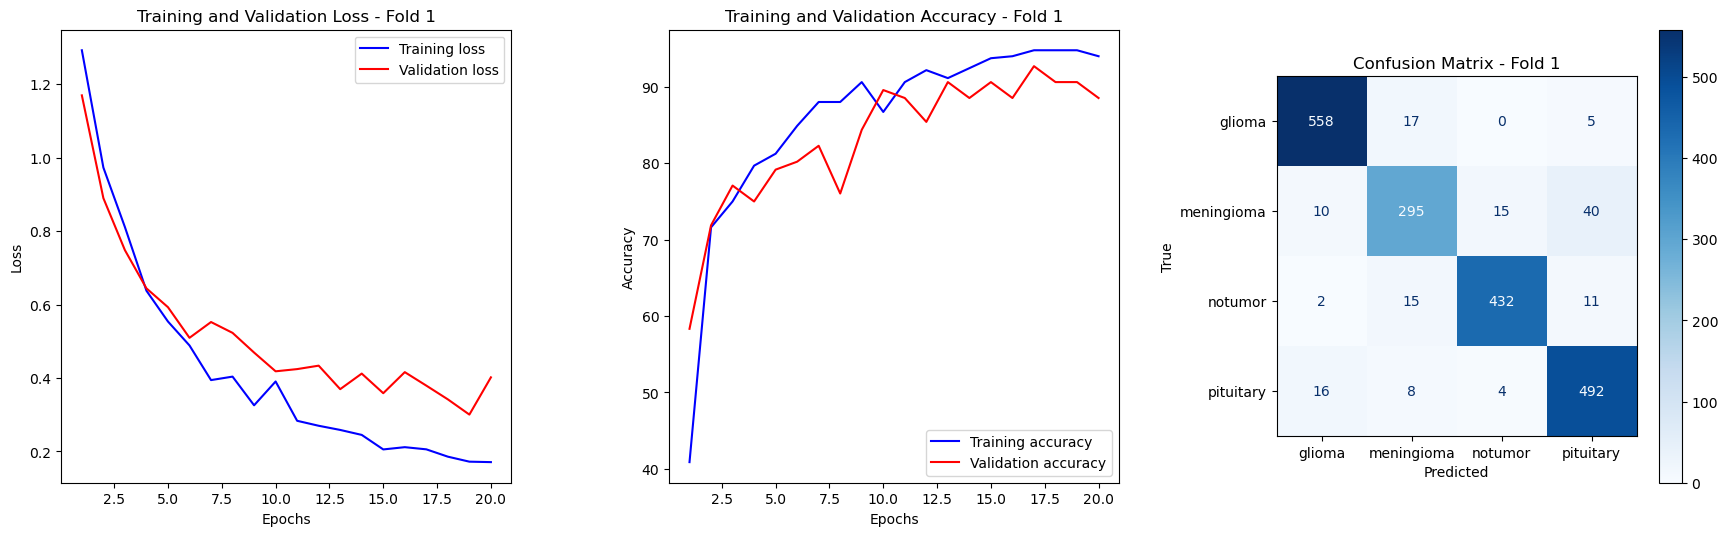

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       0.98      0.88      0.93       600
  meningioma       0.72      0.68      0.70       500
     notumor       0.76      0.91      0.83       300
   pituitary       0.84      0.89      0.86       520

    accuracy                           0.83      1920
   macro avg       0.82      0.84      0.83      1920
weighted avg       0.84      0.83      0.83      1920

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 558, TN: 1312, FP: 28, FN: 22
Class: meningioma, TP: 295, TN: 1520, FP: 40, FN: 65
Class: notumor, TP: 432, TN: 1441, FP: 19, FN: 28
Class: pituitary, TP: 492, TN: 1344, FP: 56, FN: 28
AUC-ROC for class glioma: 0.9807
AUC-ROC for class meningioma: 0.8860
AUC-ROC for class notumor: 0.9743
AUC-ROC for class pituitary: 0.9612


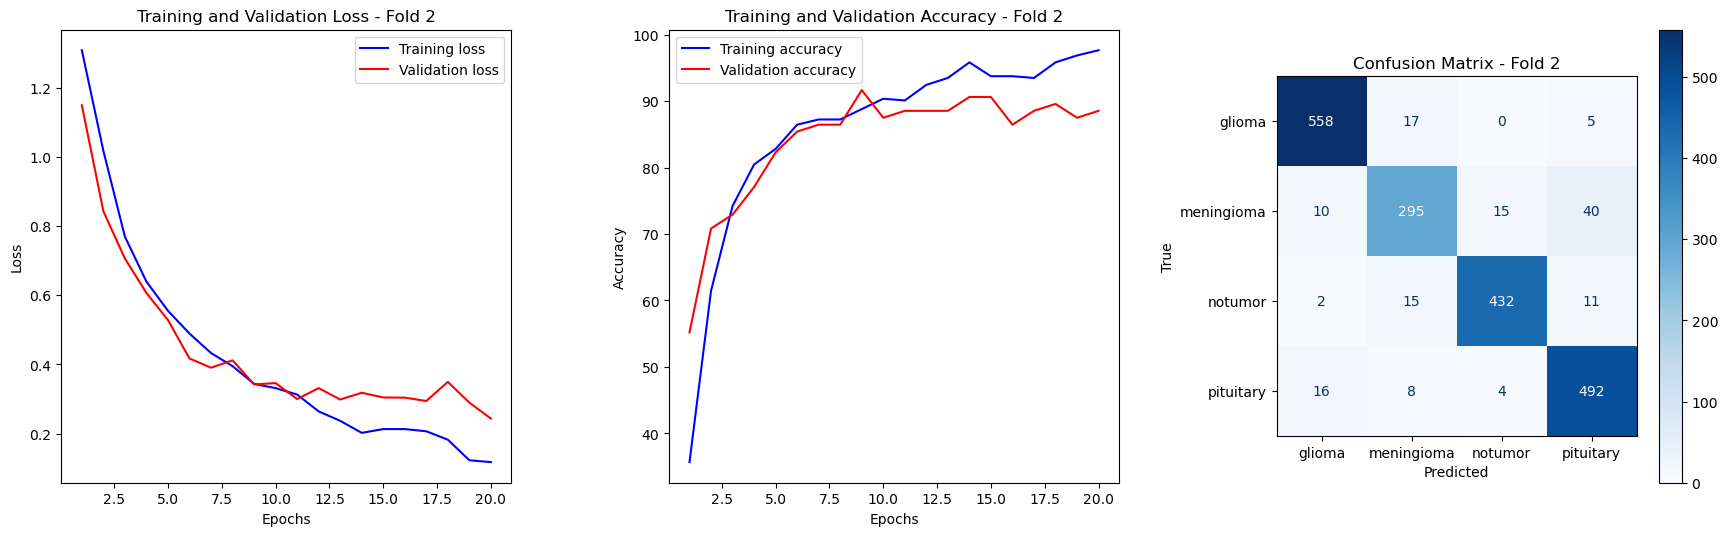

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.87      0.91      0.89       320
  meningioma       0.88      0.67      0.76       520
     notumor       0.91      0.86      0.89       600
   pituitary       0.74      0.95      0.83       480

    accuracy                           0.84      1920
   macro avg       0.85      0.85      0.84      1920
weighted avg       0.85      0.84      0.84      1920

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 558, TN: 1312, FP: 28, FN: 22
Class: meningioma, TP: 295, TN: 1520, FP: 40, FN: 65
Class: notumor, TP: 432, TN: 1441, FP: 19, FN: 28
Class: pituitary, TP: 492, TN: 1344, FP: 56, FN: 28
AUC-ROC for class glioma: 0.9797
AUC-ROC for class meningioma: 0.9356
AUC-ROC for class notumor: 0.9768
AUC-ROC for class pituitary: 0.9824


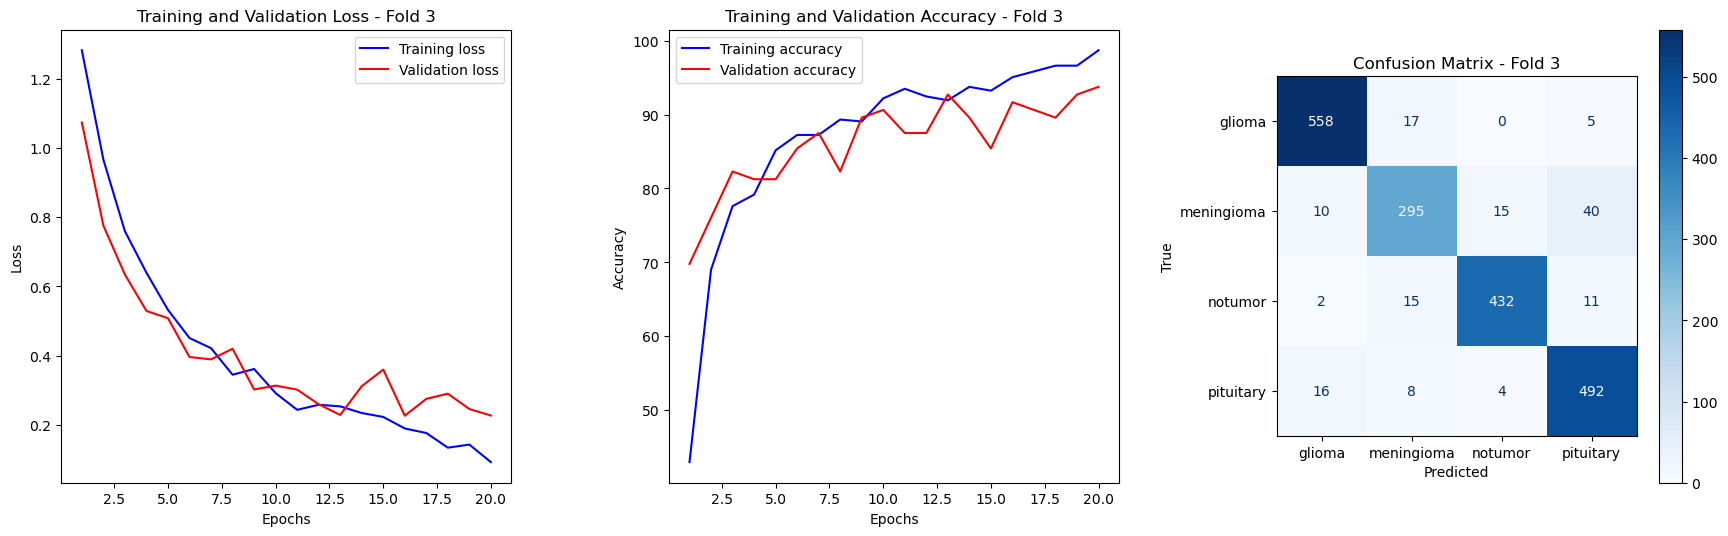

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.94      0.91      0.92       460
  meningioma       0.87      0.71      0.78       560
     notumor       0.75      0.93      0.83       440
   pituitary       0.92      0.94      0.93       460

    accuracy                           0.86      1920
   macro avg       0.87      0.87      0.87      1920
weighted avg       0.87      0.86      0.86      1920

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 558, TN: 1312, FP: 28, FN: 22
Class: meningioma, TP: 295, TN: 1520, FP: 40, FN: 65
Class: notumor, TP: 432, TN: 1441, FP: 19, FN: 28
Class: pituitary, TP: 492, TN: 1344, FP: 56, FN: 28
AUC-ROC for class glioma: 0.9896
AUC-ROC for class meningioma: 0.9413
AUC-ROC for class notumor: 0.9722
AUC-ROC for class pituitary: 0.9935


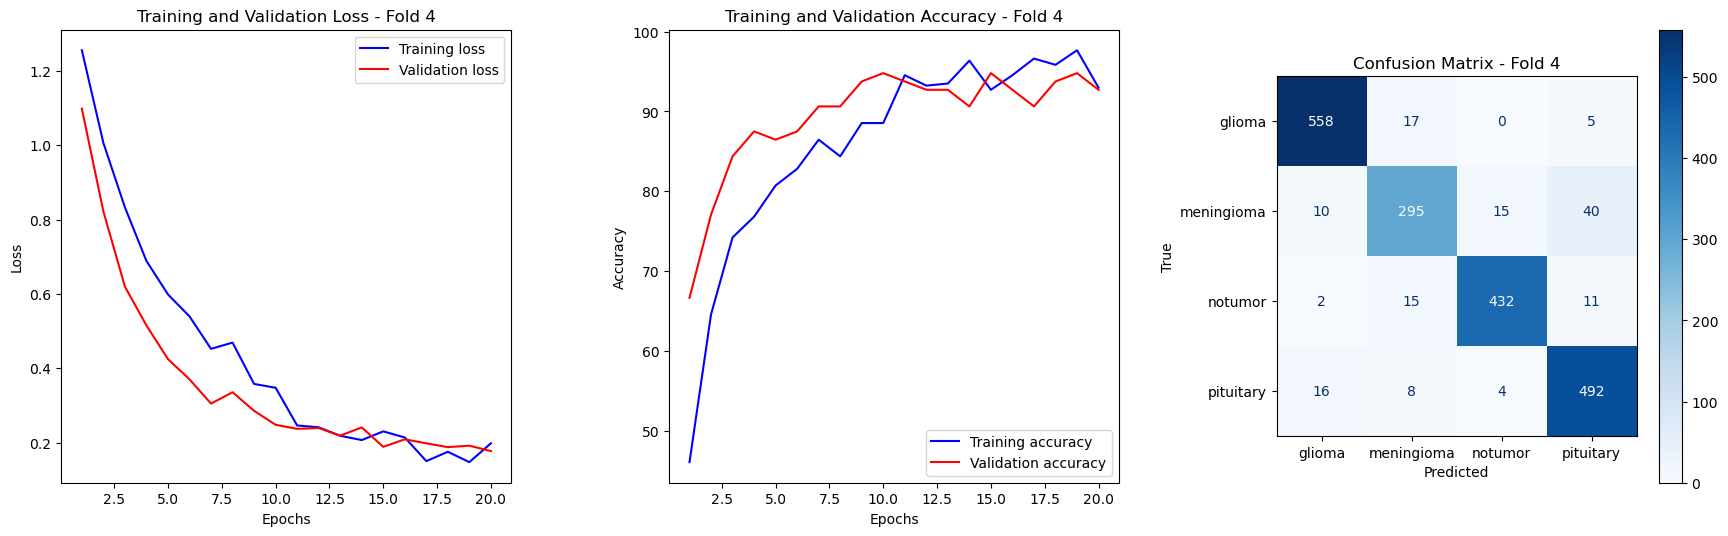

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.86      0.97      0.91       440
  meningioma       0.91      0.68      0.78       460
     notumor       0.89      0.95      0.92       600
   pituitary       0.92      0.98      0.95       420

    accuracy                           0.89      1920
   macro avg       0.90      0.89      0.89      1920
weighted avg       0.90      0.89      0.89      1920

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 558, TN: 1312, FP: 28, FN: 22
Class: meningioma, TP: 295, TN: 1520, FP: 40, FN: 65
Class: notumor, TP: 432, TN: 1441, FP: 19, FN: 28
Class: pituitary, TP: 492, TN: 1344, FP: 56, FN: 28
AUC-ROC for class glioma: 0.9925
AUC-ROC for class meningioma: 0.9560
AUC-ROC for class notumor: 0.9854
AUC-ROC for class pituitary: 0.9980
Mean Validation Accuracy across all folds: 90.89%
Variance of Validation Accuracy across all folds: 5.63%


In [10]:
# Plotting results for each fold
for fold_result in fold_results:
    plt.figure(figsize=(18, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(actual_epochs, fold_result['train_losses'], 'b', label='Training loss')
    plt.plot(actual_epochs, fold_result['val_losses'], 'r', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold_result["fold"]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(actual_epochs, fold_result['train_accuracies'], 'b', label='Training accuracy')
    plt.plot(actual_epochs, fold_result['val_accuracies'], 'r', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy - Fold {fold_result["fold"]}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Confusion Matrix
    plt.subplot(1, 3, 3)
    conf_matrix = fold_result['conf_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_dataset.classes)
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'Confusion Matrix - Fold {fold_result["fold"]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout(pad=3.0)
    plt.show()

    # Print classification report for this fold
    print(f'Classification Report for Fold {fold_result["fold"]}:')
    print(classification_report(fold_result['val_true_classes'], fold_result['val_predictions'], target_names=val_dataset.classes))

    # Calculate TP, TN, FP, FN for each class in this fold
    class_names = val_dataset.classes
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp
        tn = np.sum(conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table for this fold
    print(f"Class-wise TP, TN, FP, FN for Fold {fold_result['fold']}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")

    for i, class_auc in enumerate(fold_result['auc_roc']):
        print(f"AUC-ROC for class {val_dataset.classes[i]}: {class_auc:.4f}")


# Calculate mean and variance of validation accuracies across all folds
val_accuracies_all_folds = [result['val_accuracies'][-1] for result in fold_results]  # Take the last epoch's accuracy from each fold
mean_accuracy = np.mean(val_accuracies_all_folds)
variance_accuracy = np.var(val_accuracies_all_folds)

# Display the mean and variance
print(f'Mean Validation Accuracy across all folds: {mean_accuracy:.2f}%')
print(f'Variance of Validation Accuracy across all folds: {variance_accuracy:.2f}%')
